In [2]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [3]:
dataset = 'hand_landmarks_end.csv'
#model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
#tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 26

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 2, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 640)               0

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


42/43 [============================>.] - ETA: 0s - loss: 2.9123 - accuracy: 0.1261
Epoch 1: saving model to new_hand_classifier.hdf5
43/43 [==============================] - 2s 20ms/step - loss: 2.9105 - accuracy: 0.1263 - val_loss: 2.2488 - val_accuracy: 0.3411
Epoch 2/1000
16/43 [==========>...................] - ETA: 0s - loss: 2.1958 - accuracy: 0.2974

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/43 [========================>.....] - ETA: 0s - loss: 1.9672 - accuracy: 0.3625
Epoch 2: saving model to new_hand_classifier.hdf5
43/43 [==============================] - 0s 10ms/step - loss: 1.9054 - accuracy: 0.3826 - val_loss: 1.2222 - val_accuracy: 0.6694
Epoch 3/1000
40/43 [==========================>...] - ETA: 0s - loss: 1.1339 - accuracy: 0.6057
Epoch 3: saving model to new_hand_classifier.hdf5
43/43 [==============================] - 0s 10ms/step - loss: 1.1230 - accuracy: 0.6096 - val_loss: 0.5533 - val_accuracy: 0.8811
Epoch 4/1000
38/43 [=========================>....] - ETA: 0s - loss: 0.6808 - accuracy: 0.7802
Epoch 4: saving model to new_hand_classifier.hdf5
43/43 [==============================] - 0s 10ms/step - loss: 0.6739 - accuracy: 0.7819 - val_loss: 0.2918 - val_accuracy: 0.9578
Epoch 5/1000
43/43 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8543
Epoch 5: saving model to new_hand_classifier.hdf5
43/43 [==============================] 

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 9ms/step - loss: 8.3791e-06 - accuracy: 1.0000


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 233ms/step
[1.3415910e-14 1.6205433e-11 5.4456998e-11 6.7051477e-12 6.5374975e-18
 1.3438630e-21 3.7834838e-10 3.7499958e-11 1.2881606e-16 1.5313497e-26
 2.9339044e-19 5.0547616e-23 4.1436651e-24 6.5919097e-27 1.0000000e+00
 5.7801403e-17 2.2246696e-26 8.6069976e-17 8.7380031e-17 7.8323836e-09
 9.1544508e-32 3.1227619e-30 1.4200511e-15 1.5566652e-17 3.4978461e-12
 4.6951815e-20]
14


# Confusion matrix

57/57 [==============================] - 0s 4ms/step


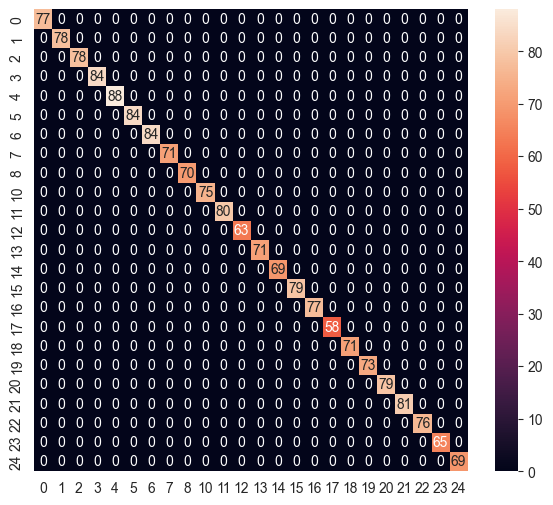

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        84
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        84
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00        71
           8       1.00      1.00      1.00        70
          10       1.00      1.00      1.00        75
          11       1.00      1.00      1.00        80
          12       1.00      1.00      1.00        63
          13       1.00      1.00      1.00        71
          14       1.00      1.00      1.00        69
          15       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        77
          17       1.00      1.00      1.00        58
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpj17xu4g0\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpj17xu4g0\assets


105472

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.2638346e-14 1.8529862e-11 6.6824636e-11 8.4625631e-12 7.0981725e-18
 1.2850751e-21 4.1488976e-10 3.9278407e-11 1.4197090e-16 1.7609933e-26
 3.1494209e-19 5.4082164e-23 4.7393675e-24 7.1534022e-27 1.0000000e+00
 6.8451022e-17 2.6681833e-26 9.9170657e-17 8.2547847e-17 7.0772641e-09
 1.1683643e-31 3.3982443e-30 1.5846104e-15 1.7199782e-17 3.5034343e-12
 4.9241506e-20]
14


In [24]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmphm97ql6j\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmphm97ql6j\assets


#### Loss  (cost)

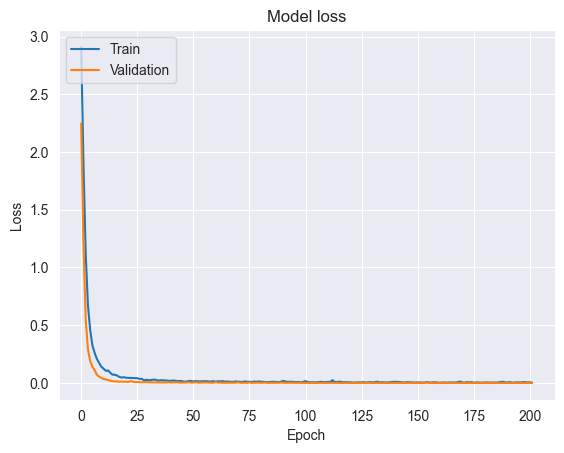

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

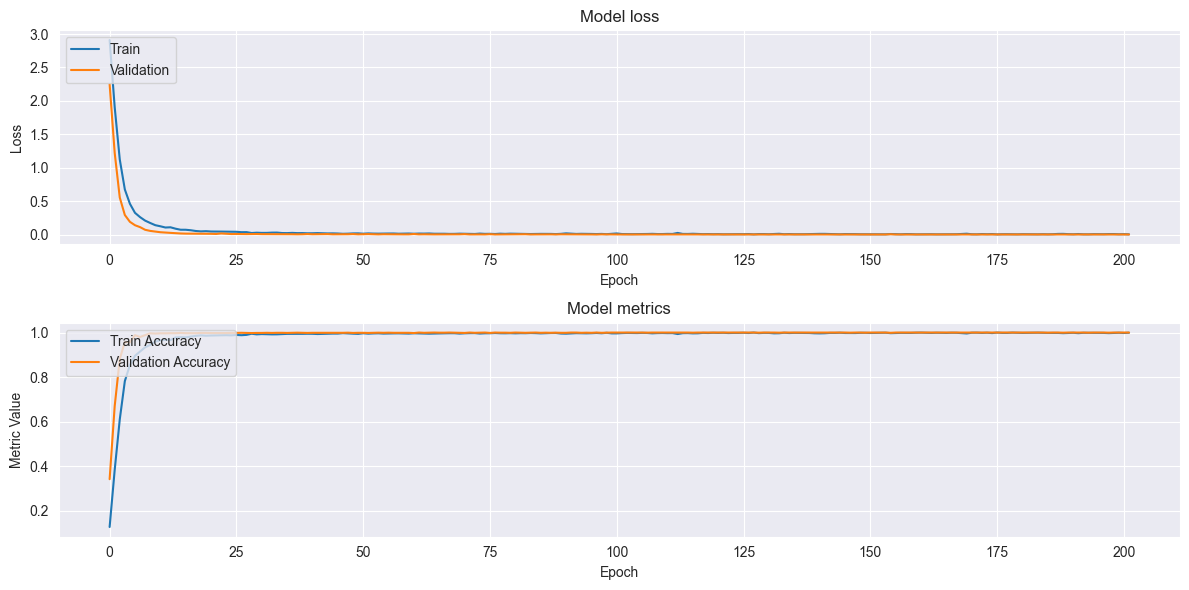

In [26]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

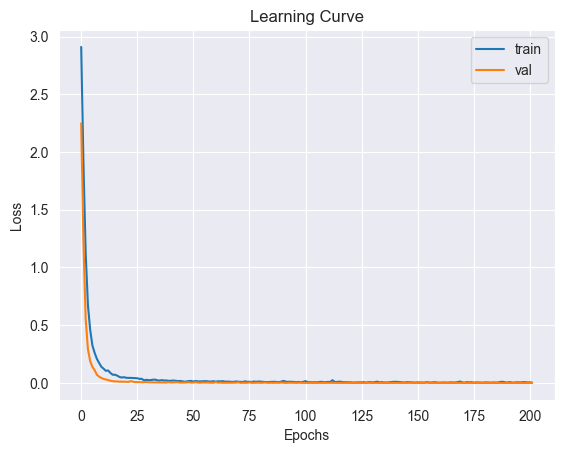

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()